# Project2_Taewoo Kim_20233219

## Text Preprocessing

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import spacy
import string
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import Normalizer
import gensim

from gensim import corpora, models, utils
from gensim.corpora.dictionary import Dictionary
from gensim.models.coherencemodel import CoherenceModel 
from gensim.parsing.preprocessing import STOPWORDS, remove_stopwords

import nltk
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize

from tensorflow import estimator

import warnings
warnings.filterwarnings(action="ignore")

[nltk_data] Downloading package punkt to C:\Users\Taewoo
[nltk_data]     Kim\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
NLP_finn = pd.read_csv('pjt2_data/NLP_finn.csv')

In [3]:
NLP_finn.groupby('Jabb')['Title'].nunique()

Jabb
Acad. Manage. J.       1774
Manage. Sci.           5394
Organ Sci.             1781
Strateg. Manage. J.    2282
Name: Title, dtype: int64

In [4]:
NLP_finn['Jabb'].describe()

count            11231
unique               4
top       Manage. Sci.
freq              5394
Name: Jabb, dtype: object

In [5]:
NLP_finn['Abst'][0]

"Theorists debate whether organizations are inertial or adaptable, but mounting evidence shows they are both, provoking questions about how shifts occur between inertia and change. Research shows performance crises can trigger reactive change, but proactive revolutions in organizations are poorly understood. In project groups, temporal pacing triggers proactive change. This longitudinal study of a venture capital-backed start-up company explored whether temporal pacing could regulate momentum and change in an organization's strategy, as it does in groups. Two forms of pacing were discovered, one time-based, with reorientations initiated at temporal milestones, the other event-based, with actions initiated when the right event occurred. The two pacing types fostered systematically different patterns of momentum and change."

### (1) Removing unnecessary string parts

In [6]:
# creating a corpus with all abstracts
corpus = [NLP_finn['Abst'][i] for i in range(len(NLP_finn['Abst']))]

In [7]:
len(corpus)

11231

In [8]:
# finding all indicies that has Copyright info
copy_index = []
for cor in corpus:
    if 'Copyright (c)' in cor:
        copy_index.append(corpus.index(cor))
    elif 'Copyright (C)' in cor:
        copy_index.append(corpus.index(cor))
    elif 'Research Summary' in cor:
        copy_index.append(corpus.index(cor))
    elif 'Research Abstract' in cor:
        copy_index.append(corpus.index(cor))
    else:
        continue

In [9]:
len(copy_index)

1884

In [10]:
# cleaning the unnecessary terms and creating a cleaned corpus
corpusn = [i.replace('Research Summary', '').replace('Research Abstract', '').replace('Research summary', '') for i in corpus]
len(corpusn)

11231

In [11]:
corpusnn = []
for i in corpusn:
    sentences = sent_tokenize(i)
    for j in sentences:
        if 'Copyright (' in j:
            sentences.remove(j)
    cleanedAbst = ' '.join(sentences) # combine strings with ' '
    corpusnn.append(cleanedAbst)

In [12]:
len(corpusnn)

11231

### (2) Removing Punctuations

In [13]:
print(len(string.punctuation))

32


In [14]:
corpus_P = [i.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation))).replace(' '*4, ' ').replace(' '*3, ' ').replace(' '*2, ' ').strip() for i in corpusnn]

In [15]:
pd.Series(corpus_P)

0        Theorists debate whether organizations are ine...
1        It has been suggested that one reason so few w...
2        Although a glass ceiling is said to keep women...
3        We challenge the claimed incommensurability of...
4        It is widely held that diversification lowers ...
                               ...                        
11226    This paper investigates how firms select refer...
11227    Can accelerators pick the most promising start...
11228    This study examines the tension between learni...
11229    In this article we explore the effects of mana...
11230    Using an organization design lens we explore h...
Length: 11231, dtype: object

In [16]:
# checking punctuation
checklist = []
for sentence in corpus_P:
    if any(char in string.punctuation for char in sentence):
        checklist.append(1)
    else:
        checklist.append(0)
if 1 in checklist:
    print("YES punctuation")
else:
    print("NO puntuation")

NO puntuation


### (3) Removing Numbers

In [17]:
corpus_PN = [i.translate(str.maketrans('', '', string.digits)) for i in corpus_P]

In [18]:
print(len(corpus_PN))

11231


In [19]:
# checking numbers
checklist = []
for sentence in corpus_PN:
    if any(char.isdigit() for char in sentence):
        checklist.append(1)
    else:
        checklist.append(0)
if 1 in checklist:
    print("YES number")
else:
    print("NO number")

NO number


### (3) Lowercasing

In [20]:
corpus_PNL = [i.lower()  for i in corpus_PN]

In [21]:
print(len(corpus_PNL))

11231


In [22]:
# checking uppercase
checklist = []
for sentence in corpus_PNL:
    if any(char.isupper() for char in sentence):
        checklist.append(1)
    else:
        checklist.append(0)
if 1 in checklist:
    print("YES uppercase")
else:
    print("NO uppercase")

NO uppercase


### (4) Lemmatizing

In [23]:
nlp = spacy.load("en_core_web_sm")

In [24]:
#corpus_PNLM = [[j.lemma_ for j in nlp(i)] for i in corpus_PNL]

In [25]:
#abst_wclm = [len(i) for i in corpus_PNLM]
#print(len(abst_wclm))

In [26]:
# removing empty strings from the results of lemmatizing
#corpus_PNLMf = [' '.join(i).split() for i in corpus_PNLM]
#len(corpus_PNLMf)

In [27]:
# checking the changes after removing empty strings
#bill_wclms = [len(i) for i in corpus_PNLMf]
#print(len(bill_wclms))
#pd.Series(bill_wclms)

In [28]:
#print(corpus[0])
#print(corpus_PNLMf[0], end="")

In [29]:
import pickle
#with open('pjt2_data/corpus_PNLMf.pickle', 'wb') as f:
#    pickle.dump(corpus_PNLMf, f)
with open('pjt2_data/corpus_PNLMf.pickle', 'rb') as f:
    corpus_PNLMf = pickle.load(f)

### (5) Removing Stopwords

In [30]:
#corpus_PNLMf[0]

In [31]:
# stopword removal with gensim library
# applied to lemmatized words
all_stopwords_add = STOPWORDS.union(set(['x', 'y', 'I', 's', 'study']))
corpus_PNLMW = [[j for j in i if not j in all_stopwords_add] for i in corpus_PNLMf]

In [32]:
# Checking if stopword removal reduced words in each bill
print(len(corpus_PNLMW))
print(corpus_PNLMW[0], end = '')
bill_wc1 = [len(i) for i in corpus_PNLMW]
pd.Series(bill_wc1)

11231
['theorist', 'debate', 'organization', 'inertial', 'adaptable', 'mount', 'evidence', 'provoke', 'question', 'shift', 'occur', 'inertia', 'change', 'research', 'performance', 'crisis', 'trigger', 'reactive', 'change', 'proactive', 'revolution', 'organization', 'poorly', 'understand', 'project', 'group', 'temporal', 'pacing', 'trigger', 'proactive', 'change', 'longitudinal', 'venture', 'capital', 'start', 'company', 'explore', 'temporal', 'pacing', 'regulate', 'momentum', 'change', 'organization', 'strategy', 'group', 'form', 'pacing', 'discover', 'time', 'base', 'reorientation', 'initiate', 'temporal', 'milestone', 'event', 'base', 'action', 'initiate', 'right', 'event', 'occur', 'pacing', 'type', 'foster', 'systematically', 'different', 'pattern', 'momentum', 'change']

0         69
1         41
2         47
3         48
4         42
        ... 
11226    154
11227    139
11228    140
11229    106
11230    128
Length: 11231, dtype: int64

* removing not helpful words

## Latent Semantic Analysis (LSA) with Scikit-learn

* making document-term frequency matrix

In [33]:
# making document title for each bill
P_names = ['p' + str(i) for i in range(len(corpus_PNLMW))]
pd.Series(P_names)

0            p0
1            p1
2            p2
3            p3
4            p4
          ...  
11226    p11226
11227    p11227
11228    p11228
11229    p11229
11230    p11230
Length: 11231, dtype: object

* finding CountVectorizer() optimal min_df & max_df

In [34]:
# making document-term frequency matrix
def feed(wordlist):
    """Use this for feeding preprocessed tokens"""
    return wordlist

# min_df와 max_df 범위 설정
min_df_range = [2, 3, 4, 5, 6, 7, 8, 9, 10]
max_df_range = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# 단어 개수의 변화율을 파악하여 최적의 매개변수 결정
opt1_min_df = None
opt1_max_df = None
cv_init = CountVectorizer(tokenizer=feed, min_df=2, max_df=0.9, ngram_range=(1, 1), token_pattern=None, lowercase=False)
X_init = cv_init.fit_transform(corpus_PNLMW)
init_word_count = X_init.sum()
threshold_word_count = init_word_count * 0.95
results = []
for min_df in min_df_range:
    for max_df in max_df_range:
        cv = CountVectorizer(tokenizer=feed, min_df=min_df, max_df=max_df, ngram_range=(1, 1), token_pattern=None, lowercase=False)
        X = cv.fit_transform(corpus_PNLMW)
        word_count = X.sum()
        if word_count <= threshold_word_count:
            results.append((min_df, max_df, word_count))
            break
    if len(results) > 0:
        break
print(f"base Word Count: {init_word_count}")
if len(results) > 0:
    opt1_min_df, opt1_max_df, opt1_word_count = results[0]
    print(f"opt1 min_df: {opt1_min_df}, opt1 max_df: {opt1_max_df}, opt1 Word Count: {opt1_word_count}")
else:
    print("No suitable combination of min_df and max_df was found.")

base Word Count: 1034132
opt1 min_df: 4, opt1 max_df: 0.3, opt1 Word Count: 979063


* finding min_df & max_df after removing more non-helpful stopwords

In [35]:
# remove normal words (by google)
top_10000_data = pd.read_csv("https://raw.githubusercontent.com/first20hours/google-10000-english/master/google-10000-english.txt", header=None)
top_10000 = list(set(top_10000_data.iloc[:,0].values))

opt2_min_df = None
opt2_max_df = None
cv_init2 = CountVectorizer(tokenizer=feed, stop_words= top_10000, min_df=2, max_df=0.9, ngram_range=(1, 1), token_pattern=None, lowercase=False)
X_init2 = cv_init2.fit_transform(corpus_PNLMW)
init2_word_count = X_init2.sum()
threshold2_word_count = init2_word_count * 0.95
results2 = []
for min_df in min_df_range:
    for max_df in max_df_range:
        cv2 = CountVectorizer(tokenizer=feed, stop_words= top_10000, min_df=min_df, max_df=max_df, ngram_range=(1, 1), token_pattern=None, lowercase=False)
        X2 = cv2.fit_transform(corpus_PNLMW)
        word_count2 = X2.sum()
        if word_count2 <= threshold2_word_count:
            results2.append((min_df, max_df, word_count))
            break
    if len(results2) > 0:
        break
print(f"base Word Count: {init2_word_count}")
if len(results2) > 0:
    opt2_min_df, opt2_max_df, opt2_word_count = results2[0]
    print(f"opt2 min_df: {opt2_min_df}, opt2 max_df: {opt2_max_df}, opt2 Word Count: {opt2_word_count}")
else:
    print("No suitable combination of min_df and max_df was found.")

base Word Count: 145347
opt2 min_df: 4, opt2 max_df: 0.3, opt2 Word Count: 979063


* dtm with base condition / dtm with optimal min_df, max_df / dtm with optimal min_df, max_df, removed more non-helpful words

In [36]:
# base dtm
base_min_df = 2
base_max_df = 0.9
base_dtm_md = CountVectorizer(tokenizer = feed, min_df = base_min_df, max_df = base_max_df, ngram_range = (1,1), token_pattern = None, lowercase = False)
base_dtfm = base_dtm_md.fit_transform(corpus_PNLMW)
#print(type(dtfm_base), dtfm_base.shape)
base_dtfm

<11231x11023 sparse matrix of type '<class 'numpy.int64'>'
	with 686377 stored elements in Compressed Sparse Row format>

In [37]:
# dtm with opt1_min_df, opt1_max_df
opt1_dtm_md = CountVectorizer(tokenizer = feed, min_df = opt1_min_df, max_df = opt1_max_df, ngram_range = (1,1), token_pattern = None, lowercase = False)
opt1_dtfm = opt1_dtm_md.fit_transform(corpus_PNLMW)
#print(type(dtfm_opt1), dtfm_opt1.shape)
opt1_dtfm

<11231x7564 sparse matrix of type '<class 'numpy.int64'>'
	with 657365 stored elements in Compressed Sparse Row format>

In [38]:
# dtm with opt_min_df, opt_max_df, remove top_10000 google stopwords
opt2_dtm_md = CountVectorizer(tokenizer = feed, stop_words=top_10000, min_df = opt2_min_df, max_df = opt2_max_df, ngram_range = (1,1), token_pattern = None, lowercase = False)
opt2_dtfm = opt2_dtm_md.fit_transform(corpus_PNLMW)
#print(type(dtfm_opt2), dtfm_opt2.shape)  
opt2_dtfm

<11231x3871 sparse matrix of type '<class 'numpy.int64'>'
	with 98471 stored elements in Compressed Sparse Row format>

In [40]:
base_dtfmx = pd.DataFrame(base_dtfm.toarray(), index=P_names, columns=base_dtm_md.get_feature_names_out()) # base
opt1_dtfmx = pd.DataFrame(opt1_dtfm.toarray(), index=P_names, columns=opt1_dtm_md.get_feature_names_out()) # opt1
opt2_dtfmx = pd.DataFrame(opt2_dtfm.toarray(), index=P_names, columns=opt2_dtm_md.get_feature_names_out()) # opt2

* DTM to document-term-list(DTL) by document (Gensim)

In [41]:
base_fin_words = base_dtm_md.inverse_transform(base_dtfm) # base
opt1_fin_words = opt1_dtm_md.inverse_transform(opt1_dtfm) # opt1
opt2_fin_words = opt2_dtm_md.inverse_transform(opt2_dtfm) # opt2

In [41]:
# mapping between unique words and word id (making a dictionary)
base_pp_dict = Dictionary(base_fin_words) # base
opt1_pp_dict = Dictionary(opt1_fin_words) # opt1
opt2_pp_dict = Dictionary(opt2_fin_words) # opt2

In [42]:
# TDF with word and ordered by frequency
# base
base_pp_tdf = list(sorted(base_pp_dict.dfs.items()))
base_tdf_pp = [(base_pp_dict[id], freq) for id, freq in sorted(base_pp_dict.dfs.items())]
# opt1
opt1_pp_tdf = list(sorted(opt1_pp_dict.dfs.items()))
opt1_tdf_pp = [(opt1_pp_dict[id], freq) for id, freq in sorted(opt1_pp_dict.dfs.items())]
# opt2
opt2_pp_tdf = list(sorted(opt2_pp_dict.dfs.items()))
opt2_tdf_pp = [(opt2_pp_dict[id], freq) for id, freq in sorted(opt2_pp_dict.dfs.items())]

In [43]:
# given a dictionary(pp_dict), make a word frequency table for each document 
# corpus_PNLMW
base_wordfreq_doc = [base_pp_dict.doc2bow(text) for text in base_fin_words]  # base
opt1_wordfreq_doc = [opt1_pp_dict.doc2bow(text) for text in opt1_fin_words]  # opt1
opt2_wordfreq_doc = [opt2_pp_dict.doc2bow(text) for text in opt2_fin_words]  # opt2

* Making tf-idf representation

In [44]:
# Calculating tf-idf matrix with scikit-learn
dtm_tfidfm = TfidfVectorizer(tokenizer = feed, min_df=5, max_df=0.8, ngram_range=(1,1), token_pattern=None, lowercase=False)
dtm_tfidf = dtm_tfidfm.fit_transform(corpus_PNLMW)
print(type(dtm_tfidf), dtm_tfidf.shape)

<class 'scipy.sparse._csr.csr_matrix'> (11231, 6798)


In [45]:
dtm_tfidf_df = pd.DataFrame(dtm_tfidf.toarray(), index=P_names, columns=dtm_tfidfm.get_feature_names_out())
#print(dtm_tfidf_df.iloc[:,0:5])

* (find optimal number of topic by explained_variance_ratio_.sum())

base


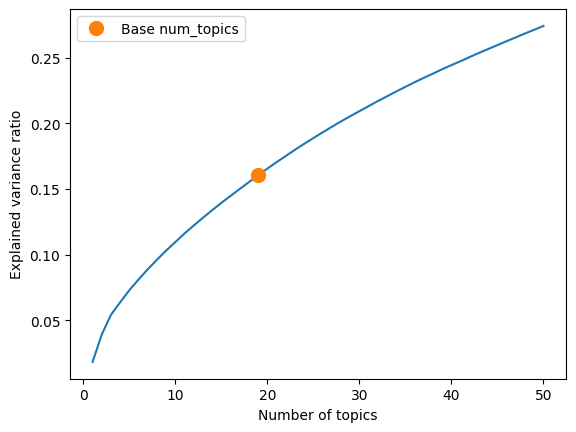

Optimal number of topics: 19 
 explained_variance_ratio: 0.16036800392223396
opt1


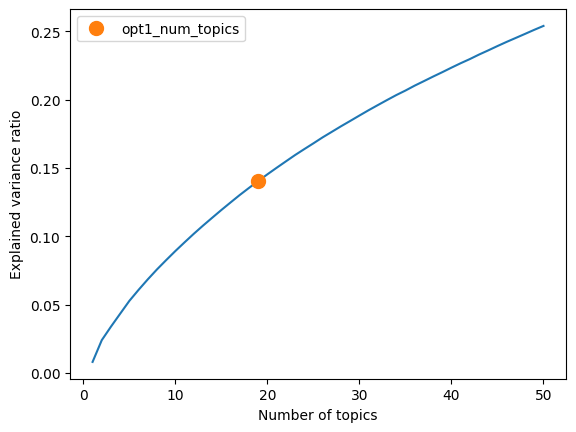

Optimal number of topics: 19 
 explained_variance_ratio: 0.14041466858471366
opt2


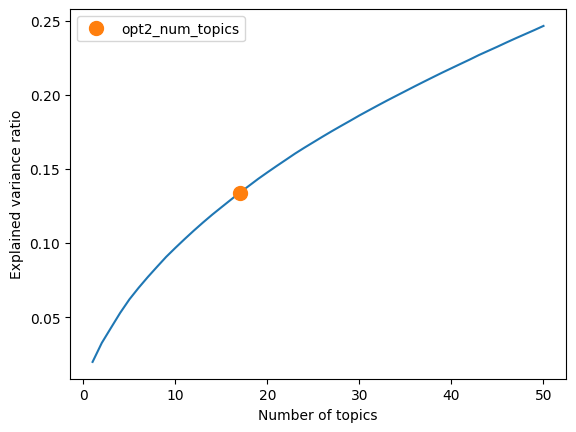

Optimal number of topics: 17 
 explained_variance_ratio: 0.13399639270619473


In [46]:
# 처음과 끝점의 평균변화율과 가장 유사한 기울기의 순간변화율을 갖는 지점을 optimal하다고 판단함
# LSA with sklearn
num_topics = 50
# find optimal number of topics by explained_variance_ratio
# base
print("base")
base_explained_variance = []
for i in range(1, num_topics+1):
    base_pp_LSA_sklm = TruncatedSVD(n_components = i, n_iter=7, random_state=42)
    base_pp_LSA_dtm_fit = base_pp_LSA_sklm.fit(base_dtfm)
    base_explained_variance.append(base_pp_LSA_dtm_fit.explained_variance_ratio_.sum())
base_diffs = np.diff(base_explained_variance)
base_slope = (base_explained_variance[-1] - base_explained_variance[0]) / num_topics
base_num_topics = np.argmin(np.abs(base_diffs - base_slope)) + 1
base_ratio = base_explained_variance[base_num_topics - 1]
# Visualize explained variances
plt.plot(range(1, num_topics+1), base_explained_variance)
plt.plot(base_num_topics, base_ratio, 'o', markersize=10, label="Base num_topics")
plt.xlabel("Number of topics")
plt.ylabel("Explained variance ratio")
plt.legend()
plt.show()
print("Optimal number of topics:", base_num_topics, '\n', "explained_variance_ratio:", base_ratio)

# opt1
print("opt1")
opt1_explained_variance = []
for i in range(1, num_topics+1):
    opt1_pp_LSA_sklm = TruncatedSVD(n_components = i, n_iter=7, random_state=42)
    opt1_pp_LSA_dtm_fit = opt1_pp_LSA_sklm.fit(opt1_dtfm)
    opt1_explained_variance.append(opt1_pp_LSA_dtm_fit.explained_variance_ratio_.sum())
opt1_diffs = np.diff(opt1_explained_variance)
opt1_slope = (opt1_explained_variance[-1] - opt1_explained_variance[0]) / num_topics
opt1_num_topics = np.argmin(np.abs(opt1_diffs - opt1_slope)) + 1
opt1_ratio = opt1_explained_variance[opt1_num_topics - 1]
# Visualize explained variances
plt.plot(range(1, num_topics+1), opt1_explained_variance)
plt.plot(opt1_num_topics, opt1_ratio, 'o', markersize=10, label="opt1_num_topics")
plt.xlabel("Number of topics")
plt.ylabel("Explained variance ratio")
plt.legend()
plt.show()
print("Optimal number of topics:", opt1_num_topics, '\n', "explained_variance_ratio:", opt1_ratio)

# opt2
print("opt2")
opt2_explained_variance = []
for i in range(1, num_topics+1):
    opt2_pp_LSA_sklm = TruncatedSVD(n_components = i, n_iter=7, random_state=42)
    opt2_pp_LSA_dtm_fit = opt2_pp_LSA_sklm.fit(opt2_dtfm)
    opt2_explained_variance.append(opt2_pp_LSA_dtm_fit.explained_variance_ratio_.sum())
opt2_diffs = np.diff(opt2_explained_variance)
opt2_slope = (opt2_explained_variance[-1] - opt2_explained_variance[0]) / num_topics
opt2_num_topics = np.argmin(np.abs(opt2_diffs - opt2_slope)) + 1
opt2_ratio = opt2_explained_variance[opt2_num_topics - 1]
# Visualize explained variances
plt.plot(range(1, num_topics+1), opt2_explained_variance)
plt.plot(opt2_num_topics, opt2_ratio, 'o', markersize=10, label="opt2_num_topics")
plt.xlabel("Number of topics")
plt.ylabel("Explained variance ratio")
plt.legend()
plt.show()
print("Optimal number of topics:", opt2_num_topics, '\n', "explained_variance_ratio:", opt2_ratio)

* LSA with DTM by Scikit-learn (opt2)

In [47]:
opt2_topiclist = ['topic' + str(i+1) for i in range(opt2_num_topics)]
opt2_pp_LSA_sklm = TruncatedSVD(n_components = opt2_num_topics, n_iter=7, random_state=42)
opt2_pp_LSA_dtm = opt2_pp_LSA_sklm.fit_transform(opt2_dtfm)

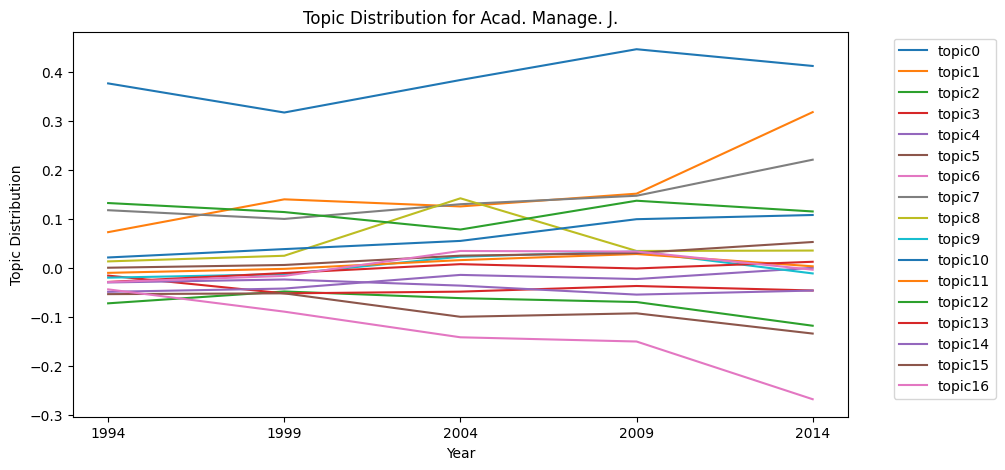

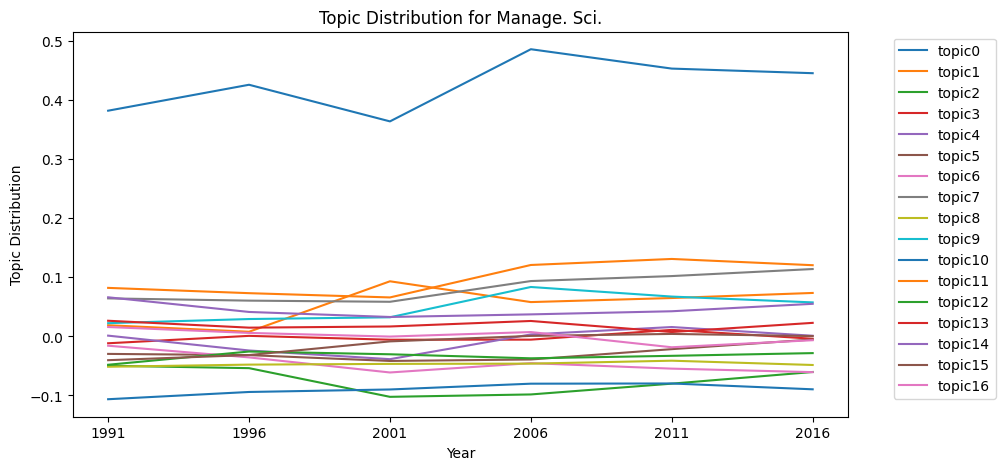

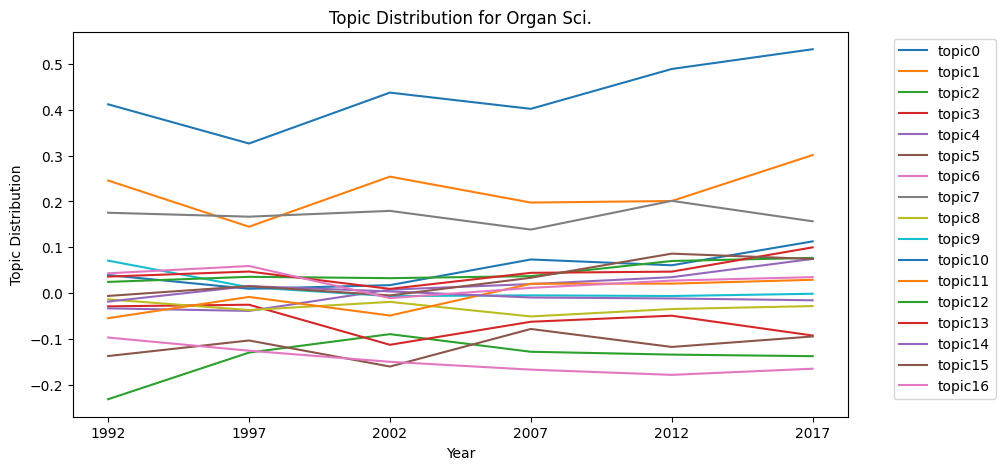

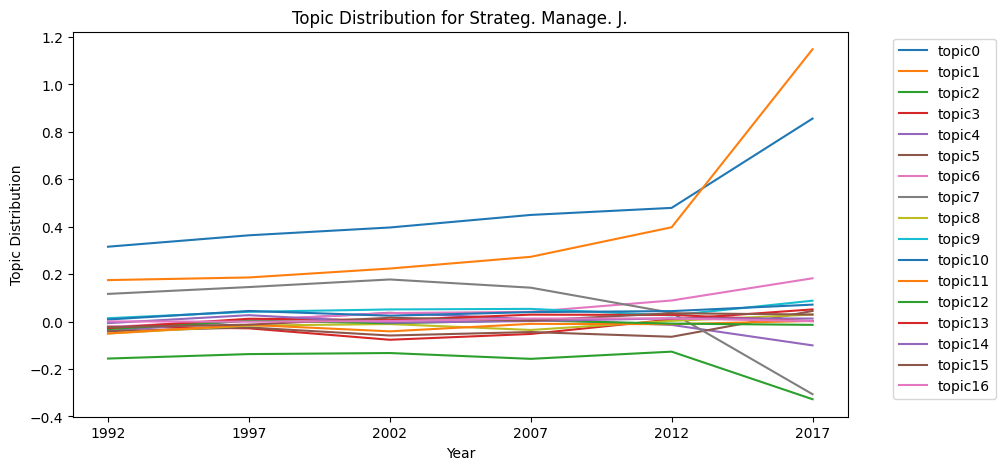

In [48]:
# 데이터 프레임에 LSA 결과를 추가
topics = ['topic'+str(i) for i in range(opt2_num_topics)]
df_lsa = pd.DataFrame(opt2_pp_LSA_dtm, columns=topics)
df_lsa = pd.concat([NLP_finn, df_lsa], axis=1)

journal_list = NLP_finn['Jabb'].unique().tolist()
# 특정 journal에 대해서 연도별 topic distribution을 시각화
for num in range(len(journal_list)):
    journal_df = df_lsa[df_lsa['Jabb'] == journal_list[num]]
    year_min = journal_df['Year'].min()
    year_max = journal_df['Year'].max()
    year_range = range(year_min, year_max+1, 5)
    topic_dist = {}
    for i in range(len(year_range)-1):
        start_year = year_range[i]
        end_year = year_range[i+1] - 1
        year_df = journal_df[(journal_df['Year'] >= start_year) & (journal_df['Year'] <= end_year)]
        topic_dist[start_year] = np.mean(year_df[topics], axis=0)

    plt.figure(figsize=(10,5))
    for i, topic in enumerate(topics):
        plt.plot(topic_dist.keys(), [x[i] for x in topic_dist.values()], label=topic)
    plt.title('Topic Distribution for '+journal_list[num])
    plt.xlabel('Year')
    plt.ylabel('Topic Distribution')
    plt.xticks(list(topic_dist.keys()))
    plt.legend(topics, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

In [49]:
#pp_topictermMtx = pd.DataFrame(pp_LSA_sklm_base.components_, index = topics_base, columns = dtm_md_base.get_feature_names_out())
#print(pp_topictermMtx.iloc[:,0:5])

In [50]:
# finding N top words for each topic
#n_words = 15
#idx_nmax_rf = [abs(row).nlargest(n_words).index for index, row in pp_topictermMtx.iterrows()]
#print(type(idx_nmax_rf))
#pd.DataFrame(idx_nmax_rf, index=topics).T

## LSA with gensim

In [51]:
'''
opt1_coherence_values = []
opt1_model_list = []
for n_topics in range(2,50,1):
    opt1_model = models.LsiModel(wordfreq_doc_opt1, num_topics = n_topics, chunksize=64, id2word=pp_dict_opt1)
    opt1_model_list.append(opt1_model)
    opt1_coherencemodel = CoherenceModel(model=opt1_model, texts=fin_words_opt1, dictionary=pp_dict_opt1, coherence='c_v')
    opt1_coherence_values.append(opt1_coherencemodel.get_coherence())
'''

"\nopt1_coherence_values = []\nopt1_model_list = []\nfor n_topics in range(2,50,1):\n    opt1_model = models.LsiModel(wordfreq_doc_opt1, num_topics = n_topics, chunksize=64, id2word=pp_dict_opt1)\n    opt1_model_list.append(opt1_model)\n    opt1_coherencemodel = CoherenceModel(model=opt1_model, texts=fin_words_opt1, dictionary=pp_dict_opt1, coherence='c_v')\n    opt1_coherence_values.append(opt1_coherencemodel.get_coherence())\n"

In [52]:
#with open('pjt2_data/opt1_coherence_values.pickle', 'wb') as f:
#    pickle.dump(opt1_coherence_values, f)
with open('pjt2_data/opt1_coherence_values.pickle', 'rb') as f:
    opt1_coherence_values = pickle.load(f)

In [53]:
'''
opt2_coherence_values = []
opt2_model_list = []
for n_topics in range(2,50,1):
    opt2_model = models.LsiModel(opt2_wordfreq_doc, num_topics = n_topics, chunksize=64, id2word=opt2_pp_dict)
    opt2_model_list.append(opt2_model)
    opt2_coherencemodel = CoherenceModel(model=opt2_model, texts=opt2_fin_words, dictionary=opt2_pp_dict, coherence='c_v')
    opt2_coherence_values.append(opt2_coherencemodel.get_coherence())
'''

"\nopt2_coherence_values = []\nopt2_model_list = []\nfor n_topics in range(2,50,1):\n    opt2_model = models.LsiModel(opt2_wordfreq_doc, num_topics = n_topics, chunksize=64, id2word=opt2_pp_dict)\n    opt2_model_list.append(opt2_model)\n    opt2_coherencemodel = CoherenceModel(model=opt2_model, texts=opt2_fin_words, dictionary=opt2_pp_dict, coherence='c_v')\n    opt2_coherence_values.append(opt2_coherencemodel.get_coherence())\n"

In [54]:
#with open('pjt2_data/opt2_coherence_values.pickle', 'wb') as f:
#    pickle.dump(opt2_coherence_values, f)
with open('pjt2_data/opt2_coherence_values.pickle', 'rb') as f:
    opt2_coherence_values = pickle.load(f)

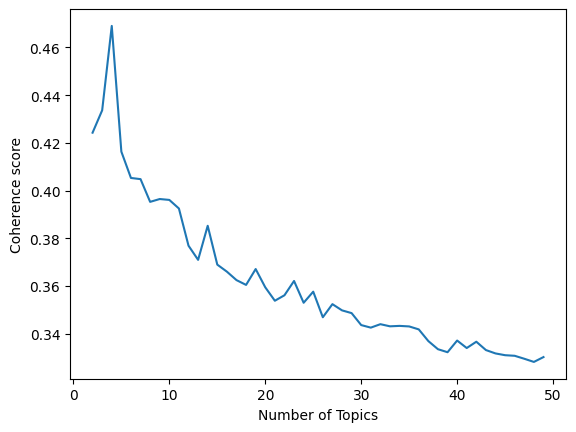

4


In [55]:
x = range(2, 50, 1)
plt.plot(x, opt1_coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.show()
gensim_opt1_num_topics = np.argmax(np.array(opt1_coherence_values))+2
print(gensim_opt1_num_topics)

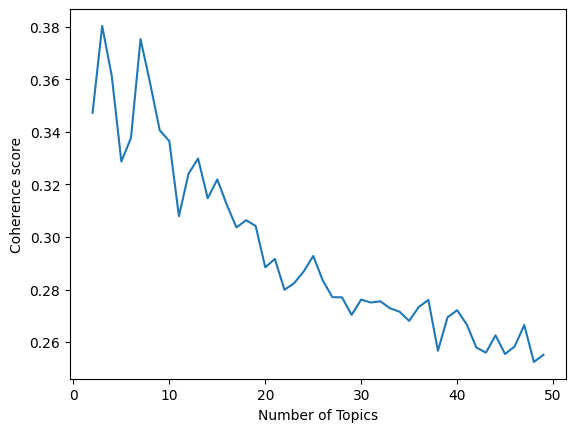

7


In [56]:
plt.plot(x, opt2_coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.show()
sorted_idx = np.argsort(np.array(opt2_coherence_values))
gensim_opt2_num_topics = sorted_idx[-2] + 2  # 7
print(gensim_opt2_num_topics)

In [64]:
opt2_model = models.LsiModel(opt2_wordfreq_doc, num_topics = gensim_opt2_num_topics, chunksize=64, id2word=opt2_pp_dict)
topic_distributions = []
for doc in opt2_wordfreq_doc:
    topic_distribution = opt2_model.get_topics()
    topic_distributions.append(topic_distribution)
topics = opt2_model.show_topics(num_topics = gensim_opt2_num_topics, num_words=15, formatted=False)
for i, topic in enumerate(topics):
    print("Topic {}: {}".format(i+1, [word[0] for word in topic[1]]))

Topic 1: ['datum', 'implication', 'managerial', 'positively', 'emerge', 'longitudinal', 'derive', 'empirically', 'perceive', 'characterize', 'illustrate', 'theorize', 'heterogeneity', 'qualitative', 'negatively']
Topic 2: ['implication', 'datum', 'managerial', 'emerge', 'perceive', 'positively', 'characterize', 'stakeholder', 'expectation', 'negatively', 'theorize', 'mediate', 'shareholder', 'emphasize', 'derive']
Topic 3: ['managerial', 'implication', 'emerge', 'datum', 'positively', 'illustrate', 'stakeholder', 'motivate', 'shareholder', 'leverage', 'competitor', 'derive', 'negatively', 'ceos', 'characterize']
Topic 4: ['characterize', 'derive', 'managerial', 'datum', 'stochastic', 'implication', 'emerge', 'induce', 'motivate', 'theorize', 'illustrate', 'heterogeneous', 'mitigate', 'uncertain', 'heuristic']
Topic 5: ['positively', 'perceive', 'negatively', 'mediate', 'longitudinal', 'theorize', 'managerial', 'characterize', 'implication', 'derive', 'hypothesize', 'stochastic', 'expec

In [66]:
opt2_model = models.LsiModel(opt2_wordfreq_doc, num_topics = gensim_opt2_num_topics, chunksize=64, id2word=opt2_pp_dict)
opt2_topic_dist = opt2_model[opt2_wordfreq_doc]
opt2_topic_dist_list = []
for doc in opt2_topic_dist:
    opt2_topic_dist_dict = dict(doc)
    opt2_topic_dist_list.append(opt2_topic_dist_dict)

topics = ['topic'+str(i) for i in range(gensim_opt2_num_topics)]
df_gensim_lsa = pd.concat([NLP_finn, pd.DataFrame.from_records(opt2_topic_dist_list, columns=topics)], axis=1)

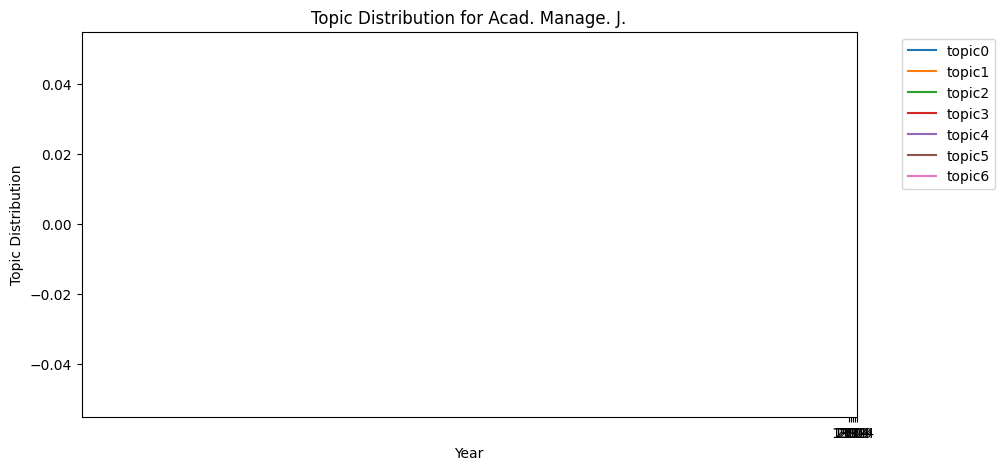

In [67]:
journal_df = df_gensim_lsa[df_gensim_lsa['Jabb'] == journal_list[0]]
year_min = journal_df['Year'].min()
year_max = journal_df['Year'].max()
year_range = range(year_min, year_max+1, 5)
topic_dist = {}
for i in range(len(year_range)-1):
    start_year = year_range[i]
    end_year = year_range[i+1] - 1
    year_df = journal_df[(journal_df['Year'] >= start_year) & (journal_df['Year'] <= end_year)]
    topic_dist[start_year] = np.mean(year_df[topics], axis=0)

plt.figure(figsize=(10,5))
for i, topic in enumerate(topics):
    plt.plot(topic_dist.keys(), [x[i] for x in topic_dist.values()], label=topic)
plt.title('Topic Distribution for '+journal_list[0])
plt.xlabel('Year')
plt.ylabel('Topic Distribution')
plt.xticks(list(topic_dist.keys()))
plt.legend(topics, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


In [71]:
df_gensim_lsa.iloc[: ,7:]

,topic0,topic1,topic2,topic3,topic4,topic5,topic6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
11226,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11227,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11228,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11229,NaN,NaN,NaN,NaN,NaN,NaN,NaN
